In [14]:
from text_mining import TextMining
import pandas as pd
import sys
sys.path.append('../src')
from database import get_last_data, get_collection
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import itertools
from tags_dict_datascience import TAGS

In [13]:
API = os.getenv("COLLECTION_API")
df = pd.DataFrame(get_last_data(collection=API))
df.head()

,_id,title,link,tags,body,is_answered,view_count,answer_count
0,689364a93ba854408272fe71,Using qKnowledgeGradient with SaasFullyBayesia...,https://stackoverflow.com/questions/79716022/u...,"[python, debugging, data-science, bayesian, bo...",<p>I’m trying to use qKnowledgeGradient with a...,False,88,0
1,689364a93ba854408272fe72,Stratefied vs Random Splitting on highly categ...,https://stackoverflow.com/questions/79694850/s...,"[machine-learning, split, data-science]",<p>I am working on a machine learning model on...,True,38,1
2,689364a93ba854408272fe73,"In &quot;statsmodels&quot; Python library, why...",https://stackoverflow.com/questions/79693109/i...,"[python, statistics, data-science, statsmodels...","<p>So to execute a z-test in python, I have se...",True,74,2
3,689364a93ba854408272fe74,Sharing Stored Cache After Reading CSV&#39;s L...,https://stackoverflow.com/questions/79687409/s...,"[r, data-science, targets-r-package]",<p>I have 760 large csv files on which i perfo...,False,52,0
4,689364a93ba854408272fe75,Identify a column cell and perform subtraction...,https://stackoverflow.com/questions/79684073/i...,"[python, pandas, data-science]","<p>This is just a small example DataFrame, but...",True,71,1


In [3]:
def build_clean_text(self, output_column="clean_text"):
    self.df[output_column] = self.df[self.token_column].apply(lambda tokens: " ".join(tokens))
    return self

In [4]:
tm_body = TextMining(df, text_column="body", tokens_column="tokens_body")
df = (
    tm_body.lowercase()
            .decode_html()  
            .remove_accents()
            .extract_url()
            .clean_regex(["body"])
            .tokenize()
            .remove_stopwords()
            .remove_short_tokens(min_len=3)
            .remove_long_tokens(max_len=20)
            .remove_numeric_tokens()
            .remove_custom_noise()
            .remove_repeated_tokens()
            .remove_tokens_starting_with_html_custom()  
            .apply_lemmatizer()
            .build_clean_text("clean_body")
            .get_df()
)

tm_title = TextMining(df, text_column="title", tokens_column="tokens_title")
df = (
    tm_title.lowercase()
            .decode_html() 
            .remove_accents()
            .extract_url()
            .clean_regex(["title"])
            .tokenize()
            .remove_stopwords()
            .remove_short_tokens(min_len=3)
            .remove_long_tokens(max_len=20)
            .remove_numeric_tokens()
            .remove_custom_noise()  
            .remove_repeated_tokens()
            .remove_tokens_starting_with_html_custom()  
            .apply_lemmatizer()
            .build_clean_text("clean_title")
            .get_df()
)

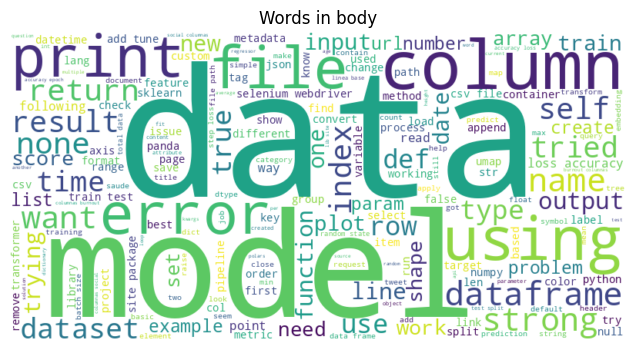

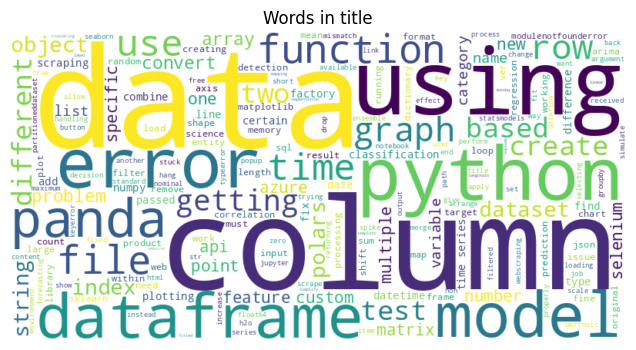

In [5]:
body = " ".join(df["clean_body"].dropna())
title = " ".join(df["clean_title"].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(body)
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Words in body")
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title)
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Words in title")
plt.show()


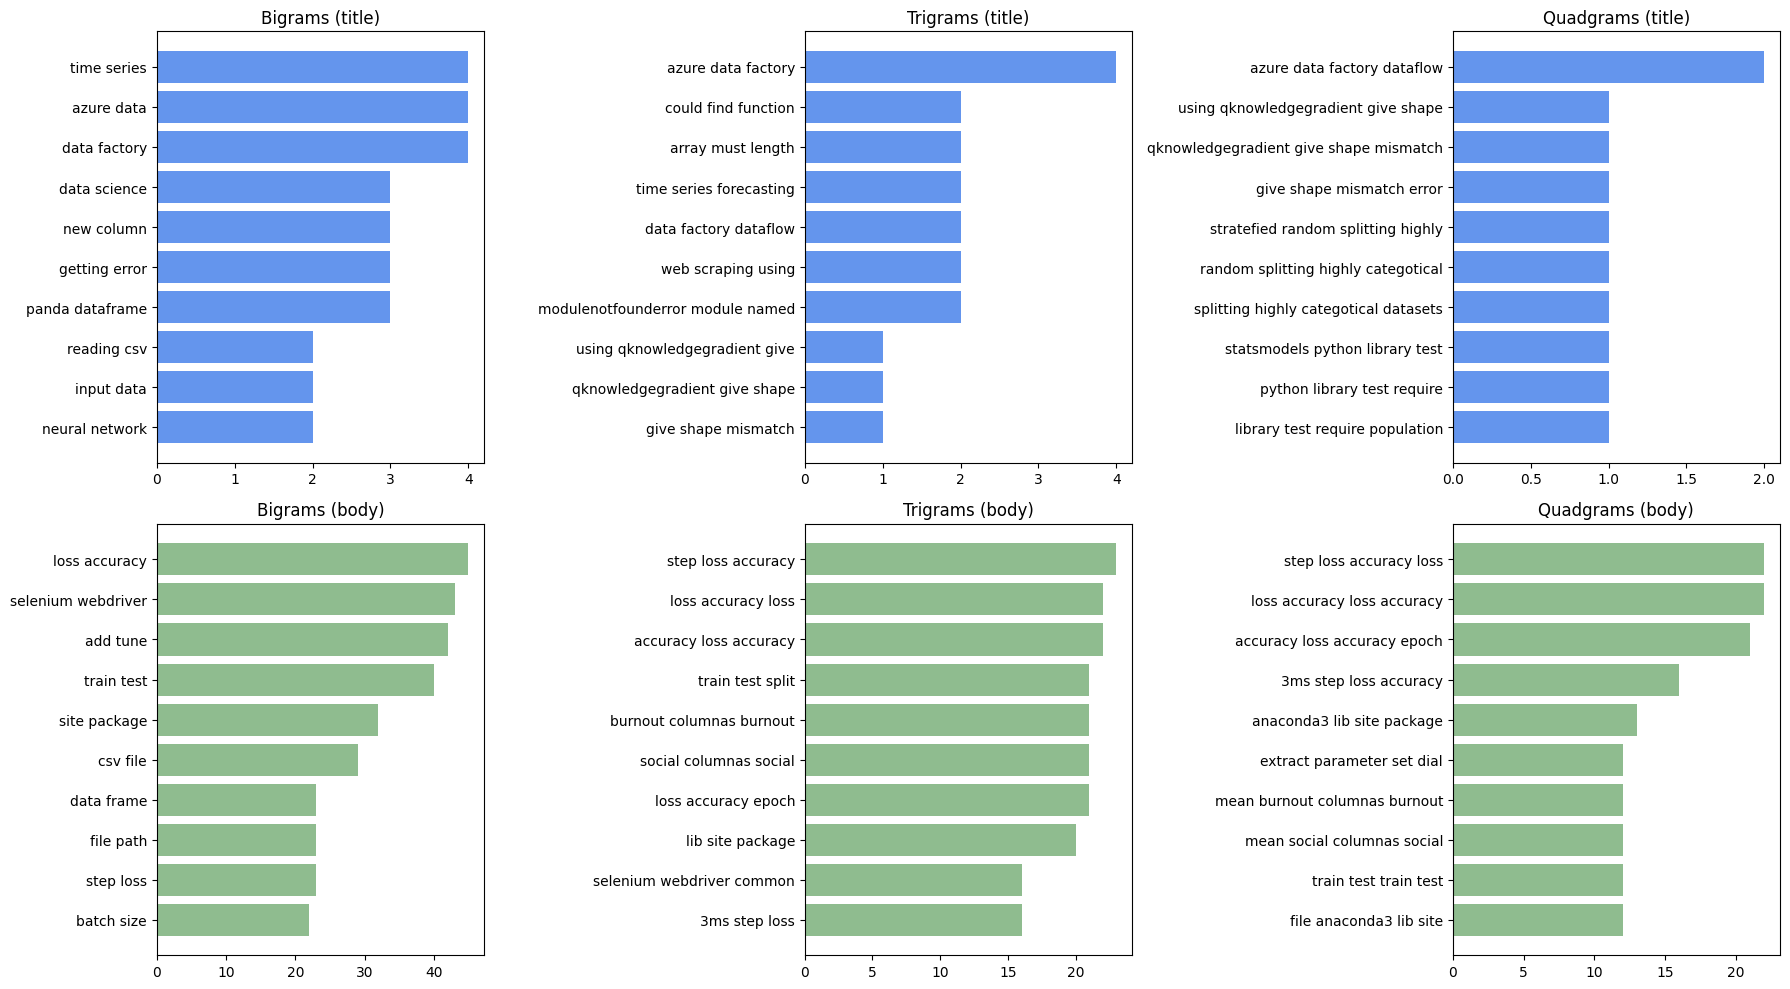

In [6]:
text_title = df["clean_title"].dropna().astype(str).tolist()
text_body = df["clean_body"].dropna().astype(str).tolist()

def plot_ngrams(corpus, n, color, title):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    sums = X.sum(axis=0)
    freqs = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    freqs = sorted(freqs, key=lambda x: x[1], reverse=True)[:10]

    words, counts = zip(*freqs)
    plt.barh(words, counts, color=color)
    plt.title(title)
    plt.gca().invert_yaxis()

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plot_ngrams(text_title, 2, 'cornflowerblue', "Bigrams (title)")
plt.subplot(2, 3, 2)
plot_ngrams(text_title, 3, 'cornflowerblue', "Trigrams (title)")
plt.subplot(2, 3, 3)
plot_ngrams(text_title, 4, 'cornflowerblue', "Quadgrams (title)")

plt.subplot(2, 3, 4)
plot_ngrams(text_body, 2, 'darkseagreen', "Bigrams (body)")
plt.subplot(2, 3, 5)
plot_ngrams(text_body, 3, 'darkseagreen', "Trigrams (body)")
plt.subplot(2, 3, 6)
plot_ngrams(text_body, 4, 'darkseagreen', "Quadgrams (body)")

plt.tight_layout()
plt.show()


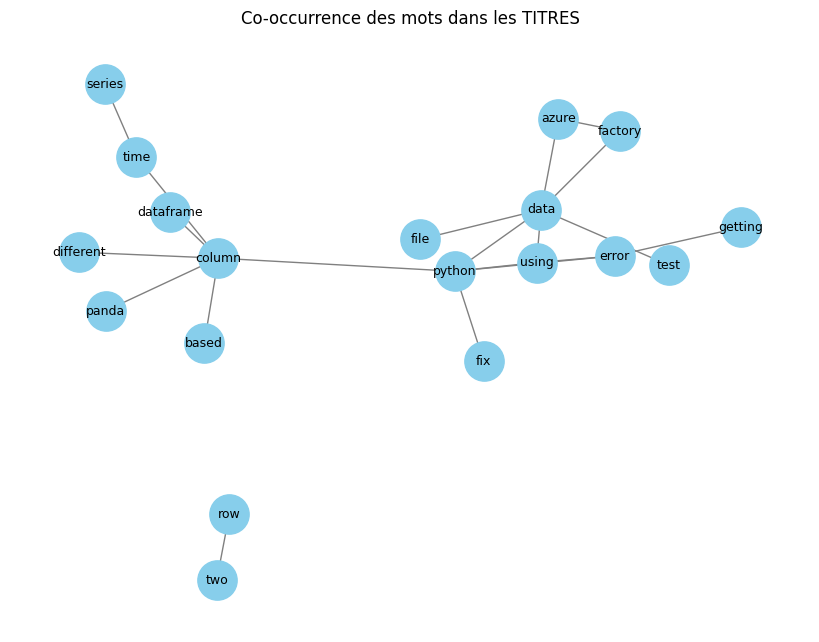

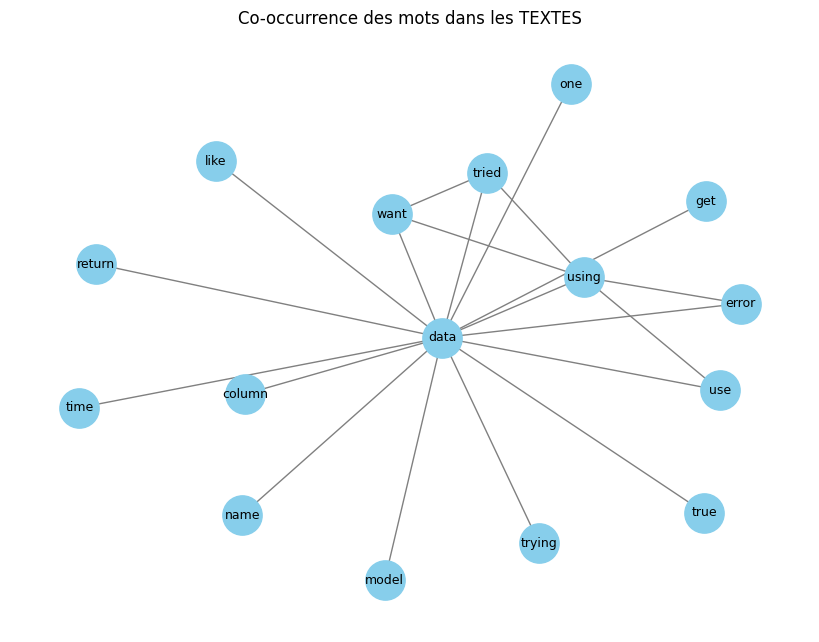

In [7]:
# S'assurer que les colonnes sont bien des listes
for col in ["tokens_title", "tokens_body"]:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

def cooc_graph(df_subset, token_column="tokens", max_edges=20, title="Co-occurrence"):
    cooc = Counter()
    for tokens in df_subset[token_column].dropna():
        tokens = eval(tokens) if isinstance(tokens, str) else tokens  # sécurité si string
        unique_tokens = set(tokens)
        for a, b in itertools.combinations(sorted(unique_tokens), 2):
            cooc[(a, b)] += 1

    cooc_df = pd.DataFrame(cooc.items(), columns=["pair", "count"])
    cooc_df = cooc_df.sort_values(by="count", ascending=False).head(max_edges)

    # Graphe
    G = nx.Graph()
    for (a, b), count in cooc_df.values:
        G.add_edge(a, b, weight=count)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, k=0.7, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=800, node_color="skyblue", edge_color="gray", font_size=9)
    plt.title(title)
    plt.axis('off')
    plt.show()

# === Graphe pour title et body ===
cooc_graph(df, token_column="tokens_title", title="Co-occurrence des mots dans les TITRES")
cooc_graph(df, token_column="tokens_body", title="Co-occurrence des mots dans les TEXTES")


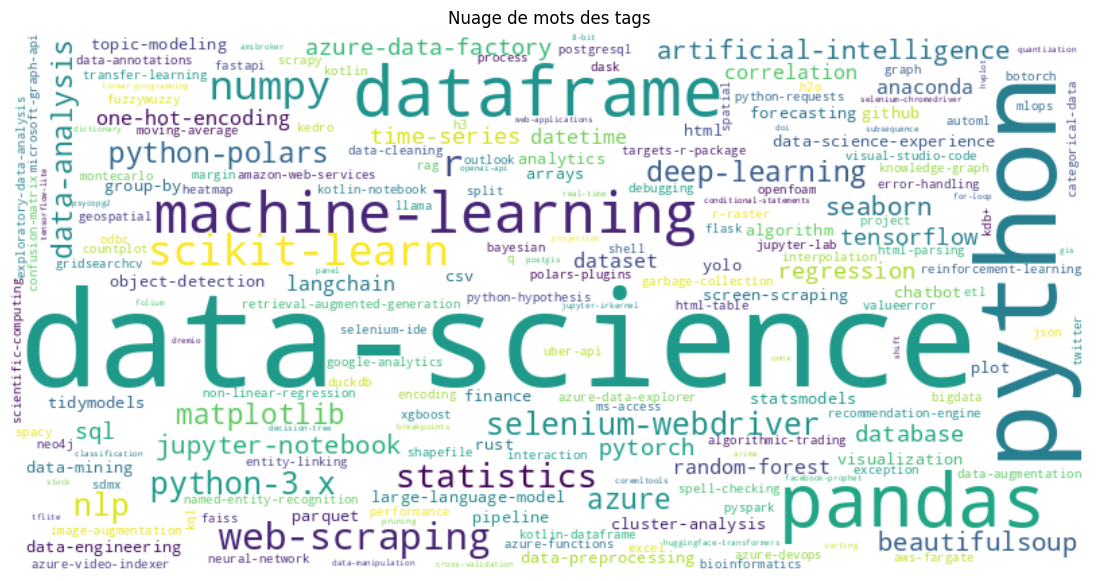

In [10]:
all_tags = [tag for tags_list in df['tags'] for tag in tags_list]

from collections import Counter
tag_counts = Counter(all_tags)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_counts)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots des tags")
plt.show()

In [11]:
tag_counts.most_common()

[('data-science', 200),
 ('python', 128),
 ('pandas', 46),
 ('dataframe', 40),
 ('machine-learning', 27),
 ('scikit-learn', 13),
 ('numpy', 12),
 ('r', 10),
 ('web-scraping', 10),
 ('statistics', 8),
 ('nlp', 7),
 ('python-3.x', 7),
 ('selenium-webdriver', 7),
 ('deep-learning', 6),
 ('matplotlib', 6),
 ('python-polars', 6),
 ('azure', 6),
 ('data-analysis', 6),
 ('artificial-intelligence', 5),
 ('beautifulsoup', 5),
 ('jupyter-notebook', 5),
 ('seaborn', 5),
 ('pytorch', 4),
 ('sql', 4),
 ('tensorflow', 4),
 ('database', 4),
 ('time-series', 4),
 ('regression', 4),
 ('azure-data-factory', 4),
 ('anaconda', 3),
 ('correlation', 3),
 ('one-hot-encoding', 3),
 ('random-forest', 3),
 ('dataset', 3),
 ('datetime', 3),
 ('langchain', 3),
 ('statsmodels', 2),
 ('object-detection', 2),
 ('yolo', 2),
 ('html', 2),
 ('large-language-model', 2),
 ('data-engineering', 2),
 ('tidymodels', 2),
 ('csv', 2),
 ('topic-modeling', 2),
 ('rust', 2),
 ('pipeline', 2),
 ('parquet', 2),
 ('github', 2),
 ('v